<a href="https://colab.research.google.com/github/Fcazarez/RRC3_IntroAI_P4_spamDetector_genreClassificator/blob/main/IntroAI_P4_0378585_Music_Genre_Classification_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **COMP-3703 (241551) Introduction to Artificial Intelligence**
# **Project 4 - Music Genre Classification + Spam detector Improvement**
# **Felix Cazarez**


> **Objectives**:
* First, implement a machine learning model to classify music files into different genres based on their audio features.
* Second, improve the spam classifier from the previous project.

> **Introduction:**
* In this assignment, you will build a neural network model that can classify music files into various genres using Mel-frequency cepstral coefficients (MFCCs) as features.
* You will use Python libraries such as Librosa for audio processing, Keras, and TensorFlow for building and training the neural network.
* Additionally, you will build a NN to improve the spam classifier
from the previous project.

> **Requirements:**
1. **`Python Libraries:`** Ensure you have librosa, keras, and tensorflow installed in your
Python environment.
2. **`Datasets:`** You will use the GTZAN genre collection. Make sure you are familiar with the
dataset before you begin working on the coding portion. You will also need the YouTube
comments dataset from the last project.
3. **`Note:`** You may use the code snippets and functions provided in class or use your own
novel approach to accomplish the tasks outlined in the problems.


# Imports

In [1]:
# mount drive to use files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

import librosa
import librosa.feature
import librosa.display
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow_datasets as tfds


from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler

from tabulate import tabulate


#`1 Data Visualization:`

* Write a function display_mfcc(song) that takes a music file as input, computes
its MFCCs, and displays the MFCCs. You may use the code provided in class for
this task or accomplish this task as you wish.
* Test this function with one song from each genre from the dataset.
* Display all of graphs for the songs you choose

In [3]:
# # get dataset
# gtzan = tfds.audio.gtzan.GTZAN()

In [4]:
url_genres= '/content/drive/MyDrive/Colab Notebooks/Intro AI/Data/genres_original'

- **`os.listdir(url_genres)`**: Lists all the items (files and directories) in the directory specified by the variable `url_genres`.

- **`for folder in os.listdir(url_genres)`**: Iterates through each item obtained in the previous step. The variable `folder` represents each item in the directory.

- **`os.path.join(url_genres, folder)`**: Joins the directory path (`url_genres`) with the current item (`folder`). This constructs the full path to the current item.

- **`os.path.isdir(os.path.join(url_genres, folder))`**: Checks if the item (after joining the path) is a directory. It returns `True` if it is a directory and `False` if it's a file.


In [5]:
# Extract genres from subfolders

# Initialize an empty list to store genre names
genres = []

# Iterate through all items (files and directories) in the specified directory
for item in os.listdir(url_genres):
    # Create the full path to the current item
    item_path = os.path.join(url_genres, item)

    # Check if the current item is a directory
    if os.path.isdir(item_path):
        # If it is a directory, add its name to the genres list
        genres.append(item)

# The 'genres' list now contains the names of all subdirectories in the specified directory


In [6]:
# Count the total number of audio files across all genres

# Iterate through each genre in the list of genres
# For each genre, count the number of files in its directory using os.listdir
# Sum up the counts for all genres to get the total number of audio files
# Calculate the total number of audio files across all genres

# Initialize a variable to store the total number of audio files
total_audios = 0

# Iterate through each genre in the list of genres
for genre in genres:
    # Construct the full path to the directory of the current genre
    genre_folder = os.path.join(url_genres, genre)

    # Count the number of audio files (files ending with '.wav') in the current genre
    audio_count = len([file for file in os.listdir(genre_folder) if file.endswith('.wav')])

    # Add the count to the total
    total_audios += audio_count

# Print the total number of audio files across all genres
print(f"Total number of audio files across all genres: {total_audios}")


Total number of audio files across all genres: 1000


File jazz.00054.wav is not working , so I copied the nextone and droped the damaged file.

In [7]:
# Count the number of audio files per genre and print the results

# Create an empty dictionary to store genre counts
genre_counts = {}

# Iterate through each genre in the list of genres
for genre in genres:
    # Construct the full path to the directory of the current genre
    genre_folder = os.path.join(url_genres, genre)

    # Count the number of audio files (files ending with '.wav') in the current genre
    audio_count = len([file for file in os.listdir(genre_folder) if file.endswith('.wav')])

    # Store the count in the genre_counts dictionary with the genre as the key
    genre_counts[genre] = audio_count

# Print the genre counts
# Convert the dictionary to a list of tuples for tabulate
table_results = list(genre_counts.items())

# Define headers for the table
headers = ["Genre", "Number of Audio Files"]

# Print the table using tabulate with "fancy_grid" format
print(tabulate([headers] + table_results, tablefmt="fancy_grid"))



╒═══════════╤═══════════════════════╕
│ Genre     │ Number of Audio Files │
├───────────┼───────────────────────┤
│ metal     │ 100                   │
├───────────┼───────────────────────┤
│ blues     │ 100                   │
├───────────┼───────────────────────┤
│ jazz      │ 100                   │
├───────────┼───────────────────────┤
│ country   │ 100                   │
├───────────┼───────────────────────┤
│ pop       │ 100                   │
├───────────┼───────────────────────┤
│ classical │ 100                   │
├───────────┼───────────────────────┤
│ reggae    │ 100                   │
├───────────┼───────────────────────┤
│ disco     │ 100                   │
├───────────┼───────────────────────┤
│ rock      │ 100                   │
├───────────┼───────────────────────┤
│ hiphop    │ 100                   │
╘═══════════╧═══════════════════════╛


In [8]:
def display_mfcc(song_path, genre):
    # Load audio file
    y, sr = librosa.load(song_path)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr)

    # Plot the MFCC spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')

    # Add colorbar and title
    plt.colorbar()
    plt.title(f'MFCC of {os.path.basename(song_path)} | Genre: {genre}')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [9]:
def get_audio_files(genre_folder):
    return [os.path.join(genre_folder, file) for file in os.listdir(genre_folder) if file.endswith('.wav')]

def display_mfcc_for_genre(genre, genre_folder):
    # Get the list of audio files in the genre subfolder
    audio_files = get_audio_files(genre_folder)

    # Display MFCC for the first audio file in the genre
    if audio_files:
        display_mfcc(audio_files[0], genre)




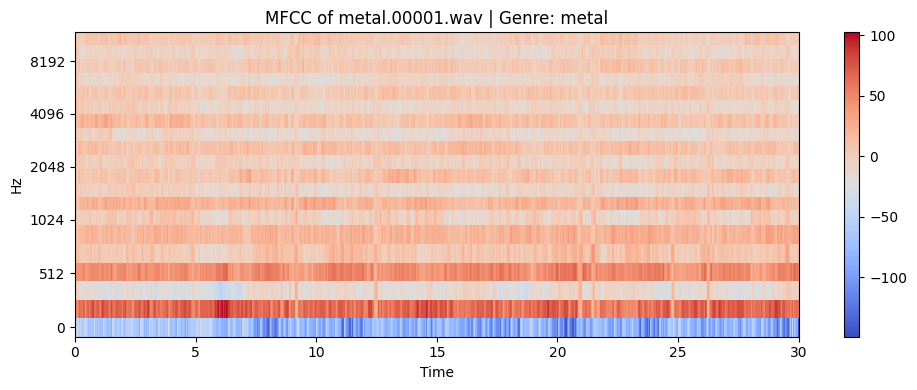

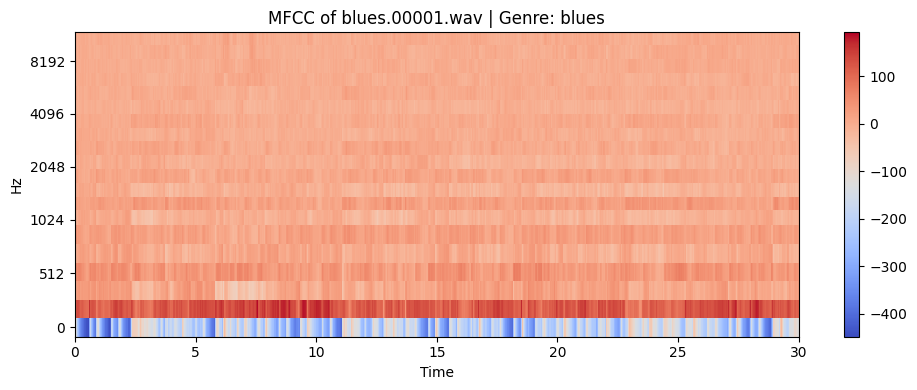

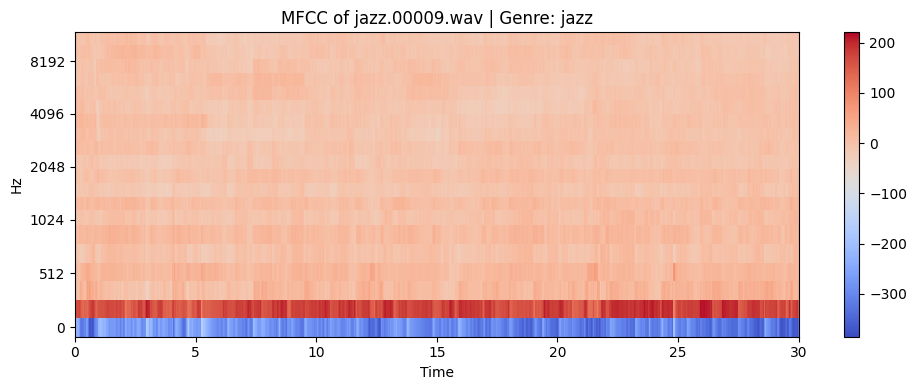

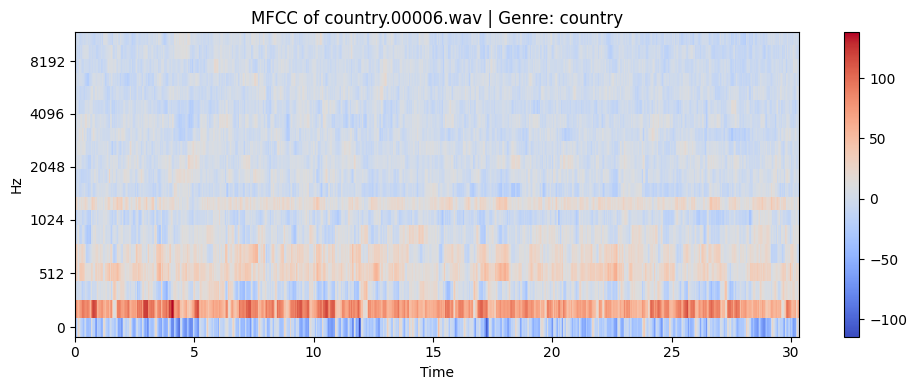

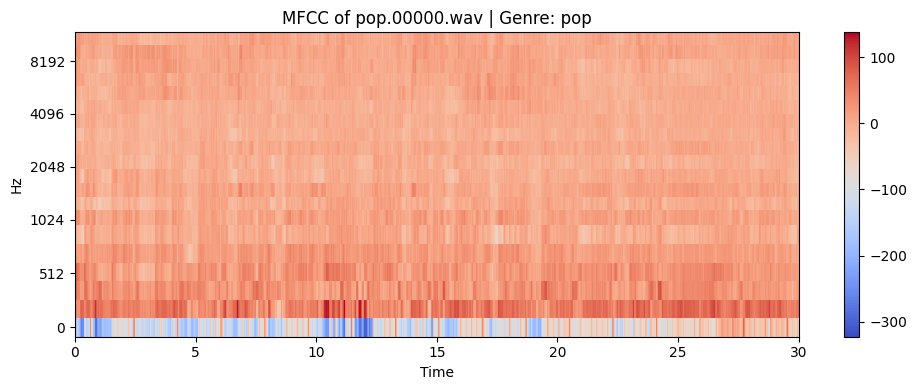

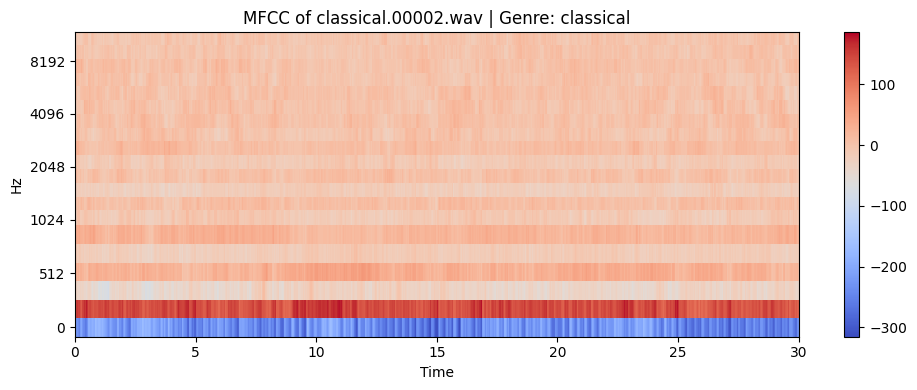

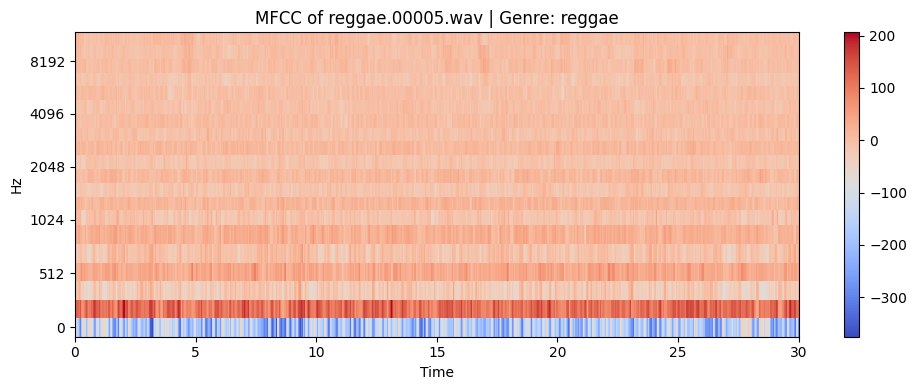

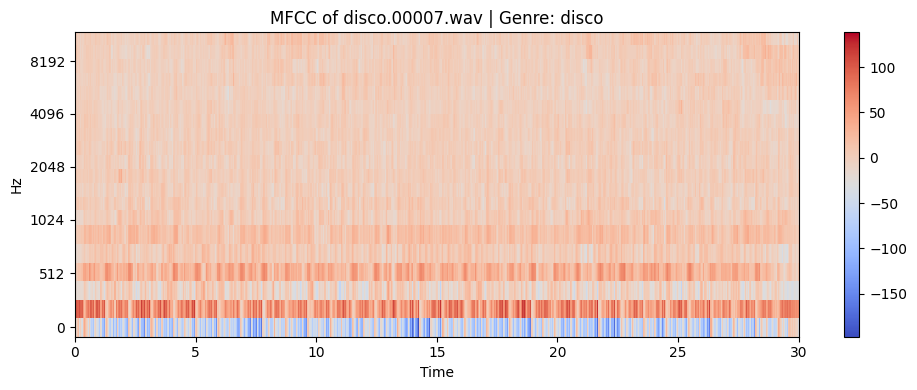

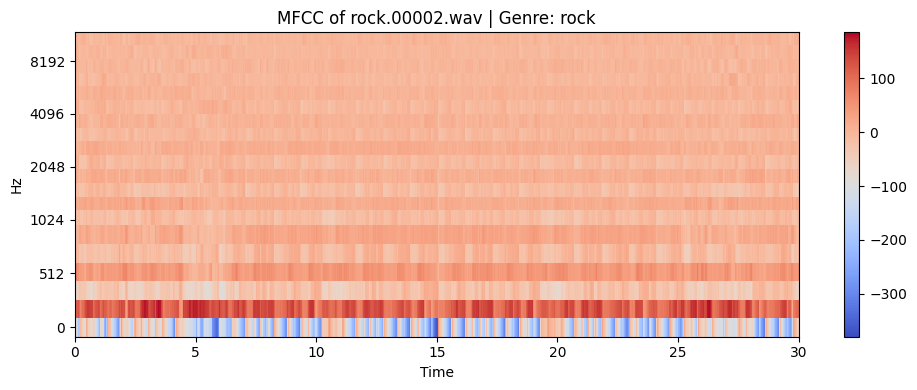

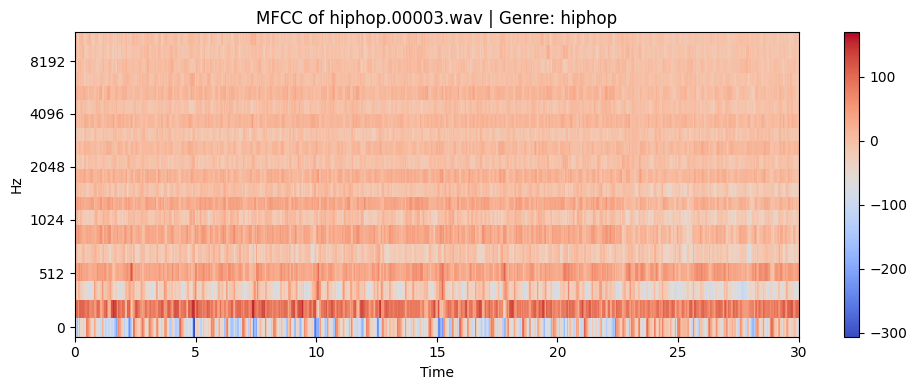

In [10]:
# one graph for each Genre
for genre in genres:
    # Get the genre subfolder
    genre_folder = os.path.join(url_genres, genre)

    # Call the function to display MFCC for the first file in each genre
    display_mfcc_for_genre(genre, genre_folder)

#`2 Feature Extraction:`
* Implement the extract_features_song(f) function to extract MFCC features
from a given song file.
* Normalize these features as done in the provided code.


In [11]:



def extract_features_song(song):
    # return np.ndarray.flatten(mfcc)[:25000]
    y, sr = librosa.load(song)

    # get Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(y=y, sr=sr)

    # normalize values between -1,1 (divide by max)
    mfcc /= np.amax(np.absolute(mfcc))

    return np.ndarray.flatten(mfcc)[:25000]

#`3. Feature and Label Preparation:`
* Modify the generate_features_and_labels() function to process all songs in
your dataset, extract features using the above function, and create genre labels for
each song.
* Convert these labels into a one-hot encoded format.


In [15]:
import os
from tabulate import tabulate

# where genre folders are located

# Create an empty dictionary to store genre counts
genre_counts = {}

# Iterate through each genre
for genre in genres:
    # Create the path to the genre folder
    genre_folder = os.path.join(url_genres, genre)

    # Use os.path.isdir to check if the path exists and is a directory
    if os.path.isdir(genre_folder):
        # List all files in the genre folder with a .au extension
        audio_files = [file for file in os.listdir(genre_folder) if file.endswith('.wav')]

        # Store the genre count in the dictionary
        genre_counts[genre] = len(audio_files)
    else:
        # Handle the case where the genre folder does not exist
        print(f"Genre folder not found for {genre}")

# Print the genre counts using tabulate
# Convert the dictionary to a list of tuples for tabulate
table_results = list(genre_counts.items())

# Define headers for the table
headers = ["Genre", "Number of Audio Files"]

# Print the table using tabulate with "fancy_grid" format
print(tabulate(table_results, headers=headers, tablefmt="fancy_grid"))



╒═══════════╤═════════════════════════╕
│ Genre     │   Number of Audio Files │
╞═══════════╪═════════════════════════╡
│ metal     │                     100 │
├───────────┼─────────────────────────┤
│ blues     │                     100 │
├───────────┼─────────────────────────┤
│ jazz      │                     100 │
├───────────┼─────────────────────────┤
│ country   │                     100 │
├───────────┼─────────────────────────┤
│ pop       │                     100 │
├───────────┼─────────────────────────┤
│ classical │                     100 │
├───────────┼─────────────────────────┤
│ reggae    │                     100 │
├───────────┼─────────────────────────┤
│ disco     │                     100 │
├───────────┼─────────────────────────┤
│ rock      │                     100 │
├───────────┼─────────────────────────┤
│ hiphop    │                     100 │
╘═══════════╧═════════════════════════╛


In [17]:
from tabulate import tabulate

def generate_features_and_labels(audio_files, genres):
    all_features = []
    all_labels = []
    genre_counts = {}

    for label, genre in enumerate(genres):
        genre_folder = os.path.join(url_genres, genre)
        genre_audio_files = [os.path.join(genre_folder, file) for file in os.listdir(genre_folder) if file.endswith('.wav')]
        print(f'Processing {len(genre_audio_files)} songs in {genre} genre...')

        # Count the number of samples per genre
        genre_counts[genre] = len(genre_audio_files)

        # Read all audios
        for audio_file in genre_audio_files:
            features = extract_features_song(audio_file)
            all_features.append(features)
            all_labels.append(label)

    # Hot-encoding
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    y_one_hot = to_categorical(label_row_ids, len(label_uniq_ids))

    # Convert the dictionary to a list of tuples for tabulate
    table_results = list(genre_counts.items())

    # Define headers for the table
    headers = ["Genre", "Number of Audio Files Processed"]

    # Print the table using tabulate with "fancy_grid" format
    print(tabulate(table_results, headers=headers, tablefmt="fancy_grid"))

    return np.stack(all_features), y_one_hot



In [18]:
# run the function generate_features_and_labels and associate to data
features, labels = generate_features_and_labels(audio_files, genres)

Processing 100 songs in metal genre...
Processing 100 songs in blues genre...
Processing 100 songs in jazz genre...
Processing 100 songs in country genre...
Processing 100 songs in pop genre...
Processing 100 songs in classical genre...
Processing 100 songs in reggae genre...
Processing 100 songs in disco genre...
Processing 100 songs in rock genre...
Processing 100 songs in hiphop genre...
╒═══════════╤═════════════════════════╕
│ Genre     │   Number of Audio Files │
╞═══════════╪═════════════════════════╡
│ metal     │                     100 │
├───────────┼─────────────────────────┤
│ blues     │                     100 │
├───────────┼─────────────────────────┤
│ jazz      │                     100 │
├───────────┼─────────────────────────┤
│ country   │                     100 │
├───────────┼─────────────────────────┤
│ pop       │                     100 │
├───────────┼─────────────────────────┤
│ classical │                     100 │
├───────────┼─────────────────────────┤
│ regg

In [19]:
print("Shape of features:", features.shape)
print("Shape of labels:", labels.shape)

Shape of features: (1000, 25000)
Shape of labels: (1000, 10)


#`4. Model Building:`
* Construct a neural network using Keras with at least two layers: a dense layer with ReLU activation and an output layer with softmax activation.
* Compile the model with appropriate loss and optimizer functions.


In [20]:
# split data (80% training, 20% testing)
training_split = 0.8

# combine features ( not the last column label) and labels
alldata = np.column_stack((features, labels))

#shuffle data
np.random.shuffle(alldata)

print(alldata.shape)

# calculate index
split_idx = int(len(alldata) * training_split)
print(split_idx)

# split data
train, test = alldata[:split_idx,:], alldata[split_idx:,:]

print(train.shape)
print(test.shape)


(1000, 25010)
800
(800, 25010)
(200, 25010)


In [21]:
# separate features and labels training
train_input = train[:, :-10]
train_labels = train[:, -10:]

# separate features and labels test
test_input = test[:, :-10]
test_labels = test[:, -10:]

In [22]:
print(f'Shape of Features: {np.shape(features)}')
print(f'Shape of Labels: {np.shape(labels)}')

training_split = 0.8

# last column has genre, turn it into unique ids
alldata = np.column_stack((features, labels))

np.random.shuffle(alldata)
splitidx = int(len(alldata) * training_split)
train, test = alldata[:splitidx,:], alldata[splitidx:,:]

print(f'Shape of Training Data: {np.shape(train)}')
print(f'Shape of Test Data: {np.shape(test)}')

train_input = train[:,:-10]
train_labels = train[:,-10:]

print(f'Shape of Training Input: {np.shape(train_input)}')
print(f'Shape of Training Labels: {np.shape(train_labels)}')

test_input = test[:,:-10]
test_labels = test[:,-10:]

print(f'Shape of Test Inputs: {np.shape(test_input)}')
print(f'Shape of Test Labels: {np.shape(test_labels)}')

Shape of Features: (1000, 25000)
Shape of Labels: (1000, 10)
Shape of Training Data: (800, 25010)
Shape of Test Data: (200, 25010)
Shape of Training Input: (800, 25000)
Shape of Training Labels: (800, 10)
Shape of Test Inputs: (200, 25000)
Shape of Test Labels: (200, 10)


# Models

In [23]:
input_shape =np.shape(train_input)[1]
input_shape

25000

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Model1_NN
model = Sequential()

# Add an input layer with ReLU activation
model.add(Dense(units=100, activation='relu', input_shape=(input_shape,)))

# Add a hidden layer with ReLU activation (you can experiment with different architectures)
model.add(Dense(units=50, activation='relu'))

# Output layer with softmax activation for multi-class classification (10 genres)
model.add(Dense(units=10, activation='softmax'))

# Compile the model with categorical_crossentropy for multi-class classification
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2500100   
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
Total params: 2505660 (9.56 MB)
Trainable params: 2505660 (9.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Model1_NN
model = Sequential()

# dense layer with ReLU activation
model.add(Dense(units=100, activation='relu', input_shape=(input_shape,)))

# output layer with softmax activation
model.add(Dense(units=10, activation='softmax'))

# compiling the model withcategorical_crossentropy, for multi-class classification (10 genres)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


In [ ]:
# model 2
model_2 = Sequential()

# Dense layer with ReLU activation
model_2.add(Dense(units=100, activation='relu', input_shape=(input_shape,)))

# dropout
model_2.add(Dropout(0.5))

model_2.add(Dense(units=64, activation='relu'))

# dropout
model_2.add(Dropout(0.5))

# output
model_2.add(Dense(units=10, activation='softmax'))

# Compiling the model
model_2.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

# Displaying the model summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               2500100   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                6464      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
Total params: 2507214 (9.56 MB)
Trainable params: 2507214 (9.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# model 2
model_2 = Sequential()

# Add a Dense layer with ReLU activation
model_2.add(Dense(units=100, activation='relu', input_shape=(input_shape,)))

# Add a Dropout layer for regularization
model_2.add(Dropout(0.5))

# Add another Dense layer with ReLU activation
model_2.add(Dense(units=64, activation='relu'))

# Add another Dropout layer for regularization
model_2.add(Dropout(0.5))

# Output layer with softmax activation for multi-class classification (10 genres)
model_2.add(Dense(units=10, activation='softmax'))

# Compile the model with categorical_crossentropy for multi-class classification
model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Display the model summary
model_2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               2500100   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                6464      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 2507214 (9.56 MB)
Trainable params: 2507214 (9.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_3 = Sequential()

# input layer
model_3.add(Dense(units=100, activation='relu', input_shape=(input_shape,)))
model_3.add(Dropout(0.5))

model_3.add(Dense(units=100, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(units=64, activation='relu'))
model_3.add(Dropout(0.5))

# output
model_3.add(Dense(units=10, activation='softmax'))

model_3.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 100)               2500100   
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                6464      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 10)               

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define a dropout rate for regularization
dropout_rate = 0.5

# Model 3
model_3 = Sequential()

# Input layer with ReLU activation and dropout
model_3.add(Dense(units=100, activation='relu', input_shape=(input_shape,)))
model_3.add(Dropout(dropout_rate))

# Additional hidden layers with ReLU activation and dropout
model_3.add(Dense(units=100, activation='relu'))
model_3.add(Dropout(dropout_rate))

model_3.add(Dense(units=64, activation='relu'))
model_3.add(Dropout(dropout_rate))

# Output layer with softmax activation for multi-class classification (10 genres)
model_3.add(Dense(units=10, activation='softmax'))

# Compile the model with categorical_crossentropy for multi-class classification
model_3.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Display the model summary
model_3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               2500100   
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                6464      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 10)               

#`5. Training and Evaluation:`
Split your data into training and testing sets and train your
model on the training data. Evaluate the performance of your model on the test data and
output the loss and accuracy. The following outlines how to appropriately prep the data,
you may use the detailed outline or prep your data as you wish

In [27]:
# define global variables
epochs = 20
batch_size = 64

In [28]:
# Train the first model
history_model_1 = model.fit(train_input, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/20
10/10 [==============================] - 2s 78ms/step - loss: 2.0926 - accuracy: 0.2734 - val_loss: 1.8088 - val_accuracy: 0.3063
Epoch 2/20
10/10 [==============================] - 1s 52ms/step - loss: 1.5558 - accuracy: 0.4781 - val_loss: 1.6353 - val_accuracy: 0.4375
Epoch 3/20
10/10 [==============================] - 0s 46ms/step - loss: 1.2322 - accuracy: 0.5906 - val_loss: 1.4765 - val_accuracy: 0.4313
Epoch 4/20
10/10 [==============================] - 0s 51ms/step - loss: 0.9632 - accuracy: 0.7219 - val_loss: 1.4795 - val_accuracy: 0.4313
Epoch 5/20
10/10 [==============================] - 0s 43ms/step - loss: 0.7921 - accuracy: 0.7953 - val_loss: 1.5359 - val_accuracy: 0.4375
Epoch 6/20
10/10 [==============================] - 0s 47ms/step - loss: 0.6555 - accuracy: 0.8266 - val_loss: 1.4422 - val_accuracy: 0.4812
Epoch 7/20
10/10 [==============================] - 0s 49ms/step - loss: 0.5146 - accuracy: 0.8906 - val_loss: 1.3968 - val_accuracy: 0.4688
Epoch 8/20
10

In [29]:
# Train the second model
history_model_2 = model_2.fit(train_input, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/20
10/10 [==============================] - 2s 80ms/step - loss: 2.6134 - accuracy: 0.1203 - val_loss: 2.2248 - val_accuracy: 0.2188
Epoch 2/20
10/10 [==============================] - 0s 47ms/step - loss: 2.3226 - accuracy: 0.1594 - val_loss: 2.2141 - val_accuracy: 0.2250
Epoch 3/20
10/10 [==============================] - 0s 46ms/step - loss: 2.2210 - accuracy: 0.1750 - val_loss: 2.1561 - val_accuracy: 0.2625
Epoch 4/20
10/10 [==============================] - 0s 47ms/step - loss: 2.1580 - accuracy: 0.2219 - val_loss: 2.0589 - val_accuracy: 0.2812
Epoch 5/20
10/10 [==============================] - 0s 47ms/step - loss: 2.1145 - accuracy: 0.2266 - val_loss: 2.0068 - val_accuracy: 0.3250
Epoch 6/20
10/10 [==============================] - 0s 48ms/step - loss: 2.0589 - accuracy: 0.2453 - val_loss: 1.9827 - val_accuracy: 0.3500
Epoch 7/20
10/10 [==============================] - 0s 46ms/step - loss: 2.0013 - accuracy: 0.2672 - val_loss: 1.9201 - val_accuracy: 0.2937
Epoch 8/20
10

In [31]:
# Train the second model
history_model_3 = model_3.fit(train_input, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)


Epoch 1/20
10/10 [==============================] - 1s 78ms/step - loss: 1.8489 - accuracy: 0.2969 - val_loss: 1.8811 - val_accuracy: 0.3375
Epoch 2/20
10/10 [==============================] - 1s 72ms/step - loss: 1.8927 - accuracy: 0.2859 - val_loss: 1.8721 - val_accuracy: 0.3438
Epoch 3/20
10/10 [==============================] - 1s 68ms/step - loss: 1.8761 - accuracy: 0.2969 - val_loss: 1.8388 - val_accuracy: 0.3688
Epoch 4/20
10/10 [==============================] - 1s 69ms/step - loss: 1.8339 - accuracy: 0.3047 - val_loss: 1.8389 - val_accuracy: 0.3625
Epoch 5/20
10/10 [==============================] - 1s 73ms/step - loss: 1.8567 - accuracy: 0.2953 - val_loss: 1.8142 - val_accuracy: 0.3625
Epoch 6/20
10/10 [==============================] - 1s 71ms/step - loss: 1.8695 - accuracy: 0.3000 - val_loss: 1.8433 - val_accuracy: 0.3500
Epoch 7/20
10/10 [==============================] - 1s 71ms/step - loss: 1.7917 - accuracy: 0.3219 - val_loss: 1.8217 - val_accuracy: 0.3688
Epoch 8/20
10

In [32]:
# Evaluate models on the test data
test_loss_model_1, test_accuracy_model_1 = model.evaluate(test_input, test_labels, batch_size=batch_size)
test_loss_model_2, test_accuracy_model_2 = model_2.evaluate(test_input, test_labels, batch_size=batch_size)
test_loss_model_3, test_accuracy_model_3 = model_3.evaluate(test_input, test_labels, batch_size=batch_size)

4/4 [==============================] - 0s 10ms/step - loss: 2.0728 - accuracy: 0.2900


In [42]:
import pandas as pd
from tabulate import tabulate

# Function to create a table with results
def create_results_table(model_name, history, test_loss, test_accuracy):
    return {
        "Model": model_name,
        "Train Loss": history.history['loss'][-1],
        "Validation Loss": history.history['val_loss'][-1],
        "Test Loss": test_loss,
        "Train Accuracy": history.history['accuracy'][-1],
        "Validation Accuracy": history.history['val_accuracy'][-1],
        "Test Accuracy": test_accuracy
    }

# Function to display results table
def display_results_table(table_results):
    df = pd.DataFrame(table_results)
    display(df)

# Add values to the models' results table
table_results_model_1 = create_results_table('Model 1', history_model_1, test_loss_model_1, test_accuracy_model_1)
table_results_model_2 = create_results_table('Model 2', history_model_2, test_loss_model_2, test_accuracy_model_2)
table_results_model_3 = create_results_table('Model 3', history_model_3, test_loss_model_3, test_accuracy_model_3)

# Display results in a DataFrame
display_results_table([table_results_model_1, table_results_model_2, table_results_model_3])


,Model,Train Loss,Validation Loss,Test Loss,Train Accuracy,Validation Accuracy,Test Accuracy
0,Model 1,0.032656,1.563387,1.777079,1.000000,0.51250,0.485
1,Model 2,1.617726,1.763633,1.817114,0.410937,0.41875,0.410
2,Model 3,1.764071,1.823953,2.072811,0.309375,0.37500,0.290


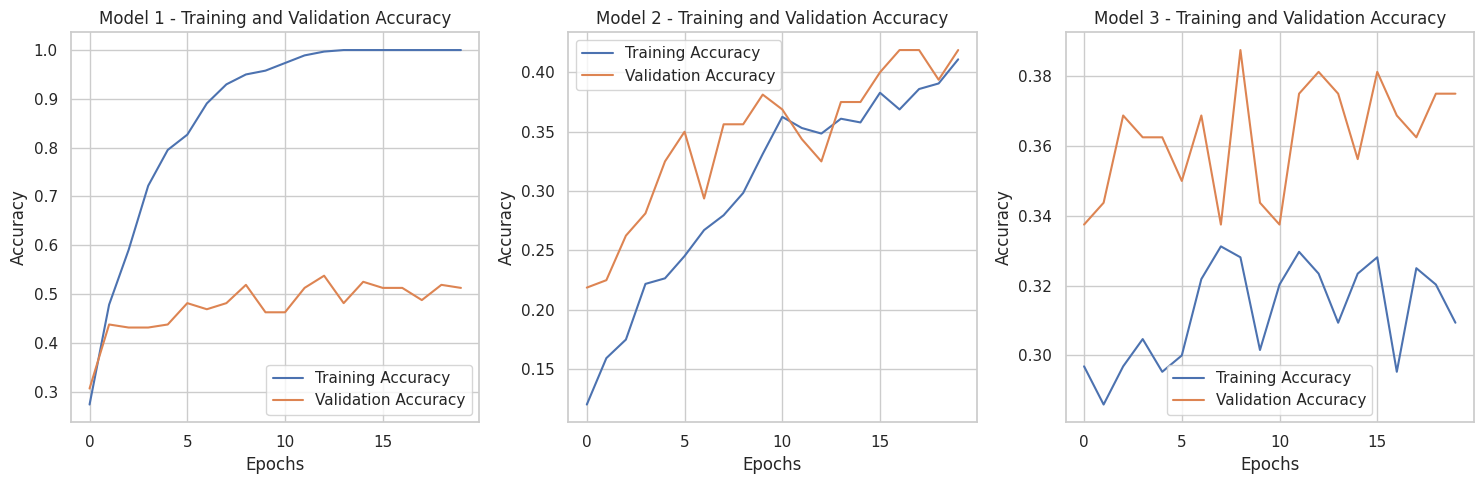

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a common style for all plots
sns.set(style="whitegrid")

# Define labels
label_t = 'Training Accuracy'
val_acc = 'Validation Accuracy'

# Function to plot training and validation accuracy
def plot_accuracy(history, model_name):
    plt.plot(history['accuracy'], label=label_t)
    plt.plot(history['val_accuracy'], label=val_acc)
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

# Plotting training and validation accuracy
plt.figure(figsize=(15, 5))

# Model 1
plt.subplot(1, 3, 1)
plot_accuracy(history_model_1.history, 'Model 1')

# Model 2
plt.subplot(1, 3, 2)
plot_accuracy(history_model_2.history, 'Model 2')

# Model 3
plt.subplot(1, 3, 3)
plot_accuracy(history_model_3.history, 'Model 3')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


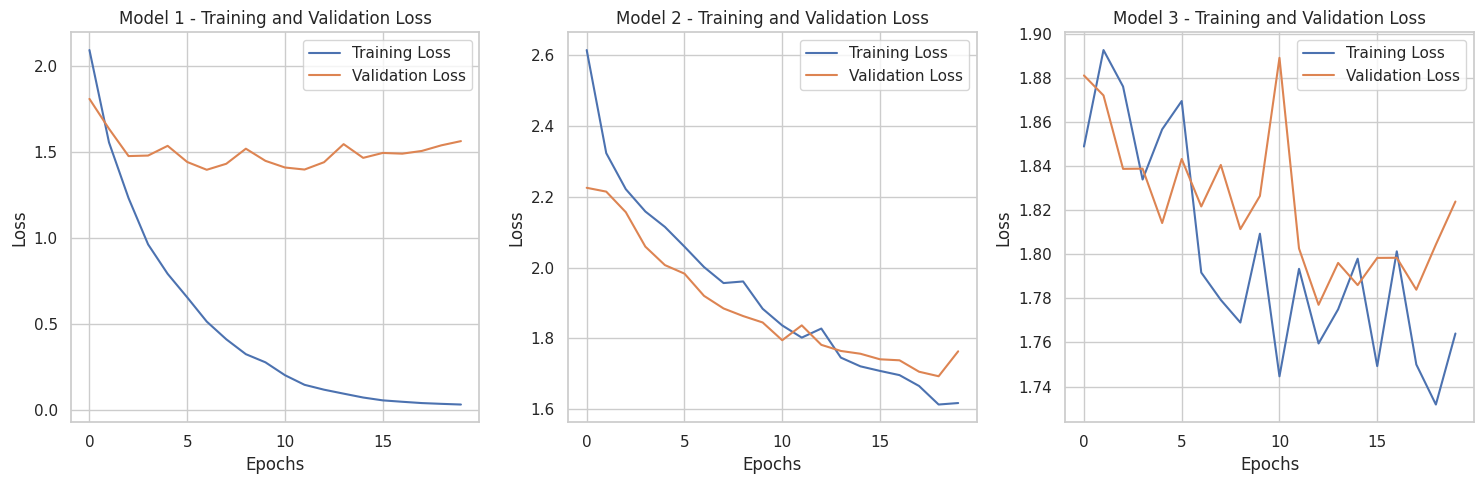

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a common style for all plots
sns.set(style="whitegrid")

# Define labels
label_t = 'Training Loss'
label_val = 'Validation Loss'

# Function to plot training and validation loss
def plot_loss(history, model_name):
    plt.plot(history['loss'], label=label_t)
    plt.plot(history['val_loss'], label=label_val)
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

# Plotting training and validation loss
plt.figure(figsize=(15, 5))

# Model 1
plt.subplot(1, 3, 1)
plot_loss(history_model_1.history, 'Model 1')

# Model 2
plt.subplot(1, 3, 2)
plot_loss(history_model_2.history, 'Model 2')

# Model 3
plt.subplot(1, 3, 3)
plot_loss(history_model_3.history, 'Model 3')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


**`Comments:`**

**`Model 1:`**

* Train Loss: 0.032656, Validation Loss: 1.563387, Test Loss: 1.777079

 -  The model performs well on the training set, achieving very low training loss. However, there's a noticeable increase in both validation and test loss, indicating potential overfitting or lack of generalization to unseen data.

* Train Accuracy: 1.000000, Validation Accuracy: 0.51250, Test Accuracy: 0.485
 - High training accuracy suggests that the model has memorized the training data, but the lower validation and test accuracy suggest it may not generalize well to new data.

**`Model 2:`**
* Train Loss: 1.617726, Validation Loss: 1.763633, Test Loss: 1.817114

 - The model seems to struggle during training, indicated by the high training loss. The validation and test loss are consistent, suggesting that the model is not overfitting, but it might be underfitting.

* Train Accuracy: 0.410937, Validation Accuracy: 0.41875, Test Accuracy: 0.410

 - The training accuracy is low, indicating that the model may not have learned the underlying patterns well. The validation and test accuracies are also low, suggesting poor performance.

**`Model 3:`**
* Train Loss: 1.764071, Validation Loss: 1.823953, Test Loss: 2.072811

 - Similar to Model 2, there's a high training loss, indicating potential underfitting. The validation and test losses are consistent, suggesting the model is not overfitting.

* Train Accuracy: 0.309375, Validation Accuracy: 0.37500, Test Accuracy: 0.290

 - Low training accuracy indicates that the model is not capturing the underlying patterns well. The validation and test accuracies are also low, indicating poor performance.

**`General Recommendations:`**
* *Overfitting and Underfitting:* Models 1 and 3 show signs of potential overfitting and underfitting, respectively. Adjust model complexity, regularization, or training duration to find a balance.

* *Hyperparameter Tuning:* Experiment with different hyperparameter values, such as learning rates, dropout rates, and the number of neurons or layers, to find the optimal configuration.

* *Evaluate Generalization:* Pay attention to the validation and test performance to ensure the models generalize well to unseen data.

* *Model Complexity:* Consider increasing or decreasing model complexity based on the observed training and validation performance.

The best model is Model 1 since has the better accuracy:

| Model 1                                  | Model 2                                         | Model 3                                       |
|------------------------------------------|-------------------------------------------------|-----------------------------------------------|
| **Strengths:**                           | **Strengths:**                                  | **Strengths:**                                |
| Very low training loss                   | Consistent performance across sets             | Consistent performance                       |
|                                          |                                                 |                                               |
| **Weaknesses:**                          | **Weaknesses:**                                 | **Weaknesses:**                               |
| Higher validation/test losses            | Low training accuracy indicates               | Low training accuracy suggests potential    |
|                                          | inadequate learning                           | underfitting                                  |
|                                          |                                                 |                                               |
| **Recommendation:**                      | **Recommendation:**                             | **Recommendation:**                           |
| Add regularization or increase complexity| Experiment with complexity, hyperparameters,   | Increase complexity, possibly by adding more |
|                                          | or train for more epochs                       | hidden layers or neurons, and monitor       |
|                                          |                                                 | the impact on training                        |


